In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmath
import datetime
from scipy.linalg import expm

In [20]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
from qutip import *
#import qutip.logging_utils as logging
#logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
#log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen

example_name = 'SX'
5.03103*(10**3)-4.92672*(10**3),-269*2*np.pi

(104.3100000000004, -1690.1768476313086)

In [3]:
cpo.optimize_pulse

<function qutip.control.pulseoptim.optimize_pulse(drift, ctrls, initial, target, num_tslots=None, evo_time=None, tau=None, amp_lbound=None, amp_ubound=None, fid_err_targ=1e-10, min_grad=1e-10, max_iter=500, max_wall_time=180, alg='GRAPE', alg_params=None, optim_params=None, optim_method='DEF', method_params=None, optim_alg=None, max_metric_corr=None, accuracy_factor=None, dyn_type='GEN_MAT', dyn_params=None, prop_type='DEF', prop_params=None, fid_type='DEF', fid_params=None, phase_option=None, fid_err_scale_factor=None, tslot_type='DEF', tslot_params=None, amp_update_mode=None, init_pulse_type='DEF', init_pulse_params=None, pulse_scaling=1.0, pulse_offset=0.0, ramping_pulse_type=None, ramping_pulse_params=None, log_level=0, out_file_ext=None, gen_stats=False)>

In [13]:
# no. of levels for each transmon.
N = 3
f_1 = 5.03648*(10**3)
f_2 = 4.96961*(10**3)
delta_1 = -268
delta_2 = -269
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      33    34     43    44
J = [[ 0.0, 4.25],[4.25, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[i])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + 0*(2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_c = [ 26.5*(2*np.pi)*Qobj(a[0].dag() + a[0])/2]
n_ctrls = len(H_c)

# start point for the gate evolution
U_0 = identity_matrix
# Target for the gate evolution - Quantum Fourier Transform gate
from qutip.qip.operations import cnot
U_targ = cnot()#(tensor(identity(2),identity(2))-1j*tensor(sigmaz(),sigmax()))*(1/np.sqrt(2))
H_d

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.         -1690.17684763     0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.         -1690.17684763     0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.         -1683.89366232     0.
      0.        ]
 [    0.       

In [9]:
(destroy(N).dag()+destroy(N))

Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.         1.         0.         0.         0.        ]
 [1.         0.         1.41421356 0.         0.        ]
 [0.         1.41421356 0.         1.73205081 0.        ]
 [0.         0.         1.73205081 0.         2.        ]
 [0.         0.         0.         2.         0.        ]]

In [15]:
U_targ = np.zeros((N**2,N**2))
    
U_targ[0][N] = 1
U_targ[N][0] = 1
U_targ[1][N+1] = 1
U_targ[N+1][1] = 1
U_targ=Qobj(U_targ)

In [110]:
# Duration of each timeslot
#dt = 0.001
# List of evolution times to try
#evo_times = [0.2, 3, 6]
#n_evo_times = len(evo_times)
evo_time = 0.060
n_ts = 60 #int(float(evo_time) / dt)
#Empty list that will hold the results for each evolution time
#results = list()

In [111]:
# Fidelity error target
fid_err_targ = 1e-7
# Maximum iterations for the optisation algorithm
max_iter = 2000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 3200
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

In [112]:
#Set to None to suppress output files
f_ext = "{}_n_ts_{}_{}_level.txt".format(example_name, n_ts,N)

In [113]:
f_ext

'SX_n_ts_60_3_level.txt'

In [114]:
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                amp_lbound=-1 , amp_ubound=1 , 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time,
                alg='CRAB', 
                dyn_type='UNIT', 
                prop_type='DIAG', 
                fid_type='UNIT', fid_params={'phase_option':'PSU'},gen_stats=True)

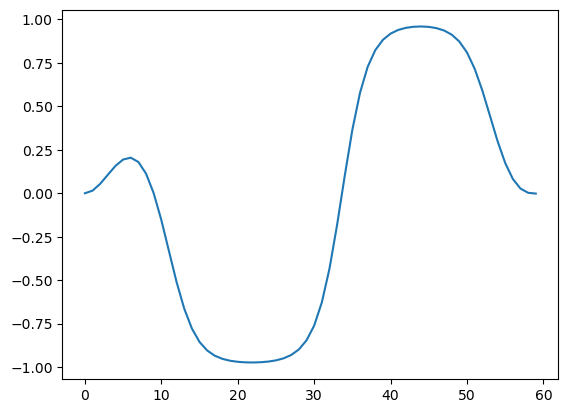

In [123]:
dyn = optim.dynamics
crab_pgen = optim.pulse_generator[0]
# Apply a ramping pulse that will force the start and end to zero
ramp_pgen = pulsegen.create_pulse_gen('GAUSSIAN_EDGE', dyn=dyn, 
                                    pulse_params={'decay_time':evo_time/500.0})
crab_pgen.ramping_pulse = ramp_pgen.gen_pulse()


# crab_pgen = optim.pulse_generator[1]
# # Apply a ramping pulse that will force the start and end to zero
# ramp_pgen = pulsegen.create_pulse_gen('GAUSSIAN_EDGE', dyn=dyn, 
#                                     pulse_params={'decay_time':evo_time/50.0})
# fff=ramp_pgen.gen_pulse()
# crab_pgen.ramping_pulse = fff



init_amps = np.zeros([n_ts, n_ctrls])
for j in range(dyn.num_ctrls):
    pgen = optim.pulse_generator[j]
    pgen.num_coeffs=5
    pgen.init_pulse()
    pgen.freqs=np.random.randint(120,150,pgen.num_coeffs)+np.random.random(pgen.num_coeffs) - 0.5
    init_amps[:, j] = pgen.gen_pulse()
#init_amps=ggg
dyn.initialize_controls(init_amps)
plt.plot(init_amps[:])

In [124]:
from scipy.fft import fft, ifft, fftfreq
import numpy as np
x = init_amps
y = fft(x)


In [57]:
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

NameError: name 'T' is not defined

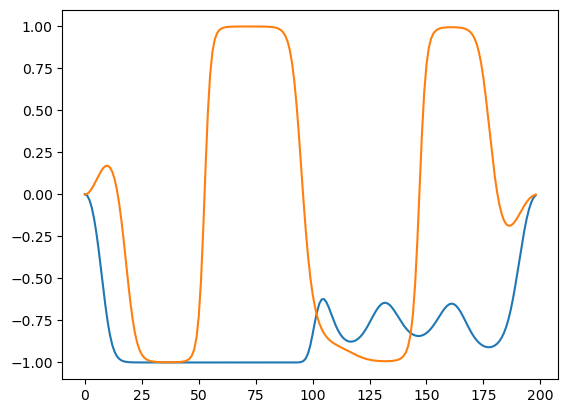

In [13]:
# Load the data from the text file, assuming the file is space-separated or tab-separated


# Replace 'your_file.txt' with the path to your actual file
data = np.loadtxt('F_0.9600129729571389fno8_CNOT_n_ts_199_2_level.txt')

# Extract the last 4 columns
last_four_columns = data[:, -2:]

# Print or return the resulting 2D numpy array
#print(np.array(last_four_columns))
plt.plot(last_four_columns)
#dyn.initialize_controls(last_four_columns)

In [60]:
last_four_columns*0.4

array([[ 6.215760e-04, -3.305120e-04],
       [-2.657944e-03,  1.342436e-03],
       [-1.301172e-02,  6.182560e-03],
       [-3.090688e-02,  1.368984e-02],
       [-5.659680e-02,  2.317700e-02],
       [-8.987880e-02,  3.379644e-02],
       [-1.297788e-01,  4.457960e-02],
       [-1.742880e-01,  5.448640e-02],
       [-2.203636e-01,  6.245280e-02],
       [-2.644020e-01,  6.742880e-02],
       [-3.031140e-01,  6.839440e-02],
       [-3.344032e-01,  6.435880e-02],
       [-3.577500e-01,  5.435640e-02],
       [-3.739548e-01,  3.747024e-02],
       [-3.845204e-01,  1.292012e-02],
       [-3.910596e-01, -1.973420e-02],
       [-3.949420e-01, -6.026360e-02],
       [-3.971740e-01, -1.073784e-01],
       [-3.984284e-01, -1.584820e-01],
       [-3.991228e-01, -2.098676e-01],
       [-3.995052e-01, -2.575152e-01],
       [-3.997156e-01, -2.982012e-01],
       [-3.998324e-01, -3.303156e-01],
       [-3.998984e-01, -3.539460e-01],
       [-3.999360e-01, -3.703420e-01],
       [-3.999580e-01, -3

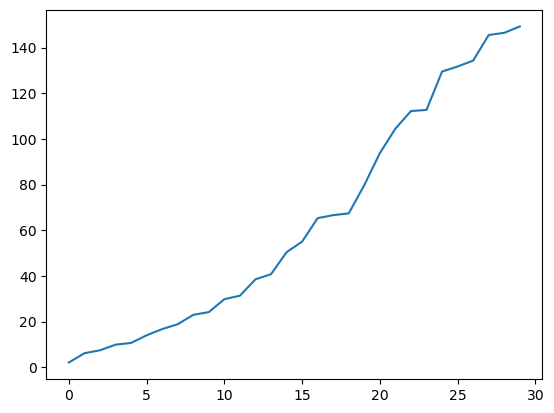

In [56]:

plt.plot(np.sort(pgen.freqs))
dd=pgen.get_optim_var_vals()

In [125]:
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("Starting pulse optimisation")
result = optim.run_optimization()

# Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)

Initial amplitudes output to file: ctrl_amps_initial_SX_n_ts_60_3_level.txt
***********************************
Starting pulse optimisation
Final amplitudes output to file: ctrl_amps_final_SX_n_ts_60_3_level.txt


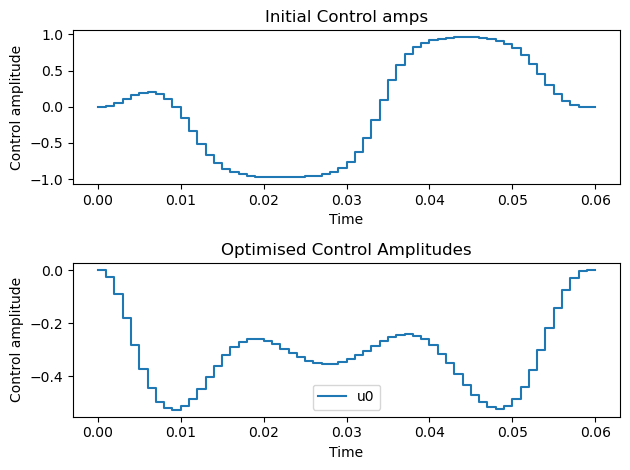

In [126]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(result.time, 
             np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])), 
             where='post')
ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(result.time, 
             np.hstack((result.final_amps[:, j], result.final_amps[-1, j])), 
             where='post', label='u{}'.format(j))
ax2.legend(loc=8, ncol=n_ctrls)
plt.tight_layout()
plt.show()


In [127]:
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity {}".format(1-result.fid_err))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))

Initial fidelity error 0.8762005466006282
Final fidelity 0.9998409948727528
Terminated due to Function converged (within tolerance)
Number of iterations 1674
Completed in 0:00:35.199924 HH:MM:SS.US


In [128]:
result.final_amps.T[0]

array([0.000000, -0.024123, -0.089393, -0.181009, -0.280953, -0.372708,
       -0.445410, -0.494660, -0.520560, -0.525366, -0.512154, -0.484503,
       -0.446620, -0.403366, -0.359873, -0.320848, -0.289877, -0.269016,
       -0.258750, -0.258247, -0.265726, -0.278870, -0.295179, -0.312262,
       -0.328041, -0.340860, -0.349533, -0.353329, -0.351952, -0.345512,
       -0.334504, -0.319801, -0.302637, -0.284576, -0.267434, -0.253175,
       -0.243759, -0.240965, -0.246192, -0.260263, -0.283221, -0.314179,
       -0.351253, -0.391640, -0.431892, -0.468311, -0.497362, -0.515931,
       -0.521391, -0.511539, -0.484617, -0.439698, -0.377551, -0.301804,
       -0.219567, -0.140577, -0.074678, -0.028824, -0.004906, 0.001239])

In [122]:
data = np.loadtxt('ctrl_amps_final_SX_n_ts_60_3_level.txt')
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
data[:,1]=data[:,1]*26.5
np.savetxt('ctrl_amps_final_SX_n_ts_60_3_level(MODIFIED).txt', data, fmt='%f', delimiter='       ', header='Time(us)  MHz', comments='')
data

array([[0.000000, -0.000000],
       [0.001000, 0.587598],
       [0.002000, 2.194497],
       [0.003000, 4.482449],
       [0.004000, 7.024832],
       [0.005000, 9.412985],
       [0.006000, 11.359649],
       [0.007000, 12.731607],
       [0.008000, 13.513118],
       [0.009000, 13.750876],
       [0.010000, 13.517411],
       [0.011000, 12.898875],
       [0.012000, 11.996020],
       [0.013000, 10.925367],
       [0.014000, 9.812314],
       [0.015000, 8.776376],
       [0.016000, 7.914331],
       [0.017000, 7.288533],
       [0.018000, 6.923628],
       [0.019000, 6.810394],
       [0.020000, 6.913771],
       [0.021000, 7.182189],
       [0.022000, 7.556369],
       [0.023000, 7.976686],
       [0.024000, 8.388866],
       [0.025000, 8.747412],
       [0.026000, 9.017499],
       [0.027000, 9.175466],
       [0.028000, 9.208458],
       [0.029000, 9.113853],
       [0.030000, 8.898859],
       [0.031000, 8.580223],
       [0.032000, 8.184022],
       [0.033000, 7.744943],
     

In [38]:
dd[1]-pgen.get_optim_var_vals()[1]

0.08783750245318811

In [68]:
U=result.evo_full_final
print("Fidelity : ",1-result.fid_err)
U*np.exp(-1j*cmath.polar(U[0][0])[1])

Fidelity :  0.8400073476309254


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.84588049+5.55111512e-17j  0.00697336+5.31563080e-01j
  -0.03993483-4.49062351e-03j  0.00196467+1.61072198e-02j]
 [-0.02273094+5.30842571e-01j  0.84487944+2.09437314e-02j
  -0.05787466-3.63141816e-03j -0.00375276-7.26705996e-03j]
 [ 0.01444743-8.53940723e-03j -0.00212624-3.38875386e-02j
  -0.12439889-5.14815983e-01j  0.8253254 -1.92075179e-01j]
 [ 0.04146168+1.32266027e-02j  0.0433416 +1.00385163e-02j
   0.82521997-1.83095077e-01j -0.110678  -5.19004143e-01j]]

In [51]:
from qutip.ipynbtools import version_table

version_table()

[[-8.01773854e-04 -3.87604723e-04]
 [ 3.36660652e-03  1.52758797e-03]
 [ 1.61376782e-02  6.91358964e-03]
 [ 3.74659854e-02  1.52582208e-02]
 [ 6.70480149e-02  2.61616583e-02]
 [ 1.04287356e-01  3.93394516e-02]
 [ 1.48265076e-01  5.46208625e-02]
 [ 1.97732304e-01  7.19422630e-02]
 [ 2.51141596e-01  9.13353216e-02]
 [ 3.06726350e-01  1.12909786e-01]
 [ 3.62624100e-01  1.36830803e-01]
 [ 4.17024105e-01  1.63290883e-01]
 [ 4.68309077e-01  1.92476929e-01]
 [ 5.15160528e-01  2.24533222e-01]
 [ 5.56607702e-01  2.59522065e-01]
 [ 5.92016100e-01  2.97384922e-01]
 [ 6.21026149e-01  3.37908240e-01]
 [ 6.43460180e-01  3.80699454e-01]
 [ 6.59215853e-01  4.25179277e-01]
 [ 6.68158899e-01  4.70595605e-01]
 [ 6.70021278e-01  5.16061581e-01]
 [ 6.64305582e-01  5.60615648e-01]
 [ 6.50194574e-01  6.03295720e-01]
 [ 6.26467763e-01  6.43214885e-01]
 [ 5.91436665e-01  6.79624171e-01]
 [ 5.42929752e-01  7.11950114e-01]
 [ 4.78389158e-01  7.39800205e-01]
 [ 3.95178932e-01  7.62935792e-01]
 [ 2.91223547e-01  7

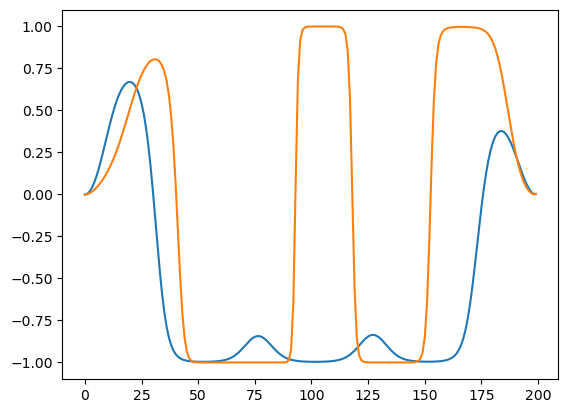

In [55]:
ggg=np.array([[-8.01773854e-04, -3.87604723e-04],
       [ 3.36660652e-03,  1.52758797e-03],
       [ 1.61376782e-02,  6.91358964e-03],
       [ 3.74659854e-02,  1.52582208e-02],
       [ 6.70480149e-02,  2.61616583e-02],
       [ 1.04287356e-01,  3.93394516e-02],
       [ 1.48265076e-01,  5.46208625e-02],
       [ 1.97732304e-01,  7.19422630e-02],
       [ 2.51141596e-01,  9.13353216e-02],
       [ 3.06726350e-01,  1.12909786e-01],
       [ 3.62624100e-01,  1.36830803e-01],
       [ 4.17024105e-01,  1.63290883e-01],
       [ 4.68309077e-01,  1.92476929e-01],
       [ 5.15160528e-01,  2.24533222e-01],
       [ 5.56607702e-01,  2.59522065e-01],
       [ 5.92016100e-01,  2.97384922e-01],
       [ 6.21026149e-01,  3.37908240e-01],
       [ 6.43460180e-01,  3.80699454e-01],
       [ 6.59215853e-01,  4.25179277e-01],
       [ 6.68158899e-01,  4.70595605e-01],
       [ 6.70021278e-01,  5.16061581e-01],
       [ 6.64305582e-01,  5.60615648e-01],
       [ 6.50194574e-01,  6.03295720e-01],
       [ 6.26467763e-01,  6.43214885e-01],
       [ 5.91436665e-01,  6.79624171e-01],
       [ 5.42929752e-01,  7.11950114e-01],
       [ 4.78389158e-01,  7.39800205e-01],
       [ 3.95178932e-01,  7.62935792e-01],
       [ 2.91223547e-01,  7.81216807e-01],
       [ 1.66033069e-01,  7.94524044e-01],
       [ 2.19438633e-02,  8.02661943e-01],
       [-1.34984965e-01,  8.05238274e-01],
       [-2.95247856e-01,  8.01507230e-01],
       [-4.47807614e-01,  7.90149248e-01],
       [-5.83023640e-01,  7.68944952e-01],
       [-6.95057622e-01,  7.34287765e-01],
       [-7.82551728e-01,  6.80497032e-01],
       [-8.47645532e-01,  5.99031873e-01],
       [-8.94303625e-01,  4.78201786e-01],
       [-9.26867989e-01,  3.05186637e-01],
       [-9.49203693e-01,  7.36866416e-02],
       [-9.64375200e-01, -2.01965304e-01],
       [-9.74643311e-01, -4.78773680e-01],
       [-9.81600249e-01, -7.04615300e-01],
       [-9.86334358e-01, -8.53734585e-01],
       [-9.89575828e-01, -9.35524847e-01],
       [-9.91809240e-01, -9.74203594e-01],
       [-9.93354314e-01, -9.90491125e-01],
       [-9.94421304e-01, -9.96736189e-01],
       [-9.95147939e-01, -9.98948204e-01],
       [-9.95623568e-01, -9.99679369e-01],
       [-9.95904672e-01, -9.99906827e-01],
       [-9.96024598e-01, -9.99973975e-01],
       [-9.95999405e-01, -9.99992949e-01],
       [-9.95831017e-01, -9.99998129e-01],
       [-9.95508406e-01, -9.99999508e-01],
       [-9.95007226e-01, -9.99999871e-01],
       [-9.94288145e-01, -9.99999966e-01],
       [-9.93294021e-01, -9.99999991e-01],
       [-9.91946145e-01, -9.99999997e-01],
       [-9.90139925e-01, -9.99999999e-01],
       [-9.87740785e-01, -1.00000000e+00],
       [-9.84581621e-01, -1.00000000e+00],
       [-9.80463905e-01, -1.00000000e+00],
       [-9.75165365e-01, -1.00000000e+00],
       [-9.68457581e-01, -1.00000000e+00],
       [-9.60136470e-01, -1.00000000e+00],
       [-9.50066589e-01, -1.00000000e+00],
       [-9.38236214e-01, -1.00000000e+00],
       [-9.24814532e-01, -1.00000000e+00],
       [-9.10196773e-01, -1.00000000e+00],
       [-8.95020455e-01, -1.00000000e+00],
       [-8.80138834e-01, -1.00000000e+00],
       [-8.66546793e-01, -1.00000000e+00],
       [-8.55267177e-01, -1.00000000e+00],
       [-8.47217213e-01, -1.00000000e+00],
       [-8.43080658e-01, -1.00000000e+00],
       [-8.43210149e-01, -1.00000000e+00],
       [-8.47577500e-01, -1.00000000e+00],
       [-8.55780247e-01, -1.00000000e+00],
       [-8.67102650e-01, -9.99999999e-01],
       [-8.80619822e-01, -9.99999997e-01],
       [-8.95325535e-01, -9.99999987e-01],
       [-9.10259553e-01, -9.99999938e-01],
       [-9.24611177e-01, -9.99999673e-01],
       [-9.37782839e-01, -9.99998170e-01],
       [-9.49408872e-01, -9.99989305e-01],
       [-9.59335856e-01, -9.99935759e-01],
       [-9.67578260e-01, -9.99609604e-01],
       [-9.74264691e-01, -9.97639108e-01],
       [-9.79587146e-01, -9.86071505e-01],
       [-9.83760529e-01, -9.22779301e-01],
       [-9.86994806e-01, -6.41269169e-01],
       [-9.89478785e-01,  5.38643719e-02],
       [-9.91372848e-01,  6.79525072e-01],
       [-9.92807667e-01,  9.14763945e-01],
       [-9.93886324e-01,  9.77182078e-01],
       [-9.94687987e-01,  9.93297696e-01],
       [-9.95271939e-01,  9.97778368e-01],
       [-9.95681289e-01,  9.99158088e-01],
       [-9.95946051e-01,  9.99632175e-01],
       [-9.96085473e-01,  9.99813606e-01],
       [-9.96109608e-01,  9.99889971e-01],
       [-9.96020164e-01,  9.99924140e-01],
       [-9.95810636e-01,  9.99938851e-01],
       [-9.95465745e-01,  9.99942409e-01],
       [-9.94960150e-01,  9.99936769e-01],
       [-9.94256400e-01,  9.99919378e-01],
       [-9.93302104e-01,  9.99881261e-01],
       [-9.92026355e-01,  9.99799381e-01],
       [-9.90335629e-01,  9.99614333e-01],
       [-9.88109610e-01,  9.99164487e-01],
       [-9.85197900e-01,  9.97982290e-01],
       [-9.81419148e-01,  9.94635506e-01],
       [-9.76564894e-01,  9.84530541e-01],
       [-9.70411058e-01,  9.52626993e-01],
       [-9.62740127e-01,  8.51919997e-01],
       [-9.53376180e-01,  5.68544770e-01],
       [-9.42232348e-01,  1.35619430e-02],
       [-9.29365929e-01, -5.54532315e-01],
       [-9.15031028e-01, -8.51793295e-01],
       [-8.99714066e-01, -9.55583859e-01],
       [-8.84136572e-01, -9.86802985e-01],
       [-8.69214282e-01, -9.95949640e-01],
       [-8.55971449e-01, -9.98688782e-01],
       [-8.45421378e-01, -9.99545806e-01],
       [-8.38433887e-01, -9.99829671e-01],
       [-8.35614367e-01, -9.99930138e-01],
       [-8.37216730e-01, -9.99968380e-01],
       [-8.43105765e-01, -9.99984088e-01],
       [-8.52775565e-01, -9.99991042e-01],
       [-8.65421231e-01, -9.99994331e-01],
       [-8.80051582e-01, -9.99995953e-01],
       [-8.95622365e-01, -9.99996736e-01],
       [-9.11164771e-01, -9.99997023e-01],
       [-9.25885640e-01, -9.99996933e-01],
       [-9.39223986e-01, -9.99996439e-01],
       [-9.50860826e-01, -9.99995358e-01],
       [-9.60690922e-01, -9.99993241e-01],
       [-9.68771845e-01, -9.99989072e-01],
       [-9.75266481e-01, -9.99980523e-01],
       [-9.80391164e-01, -9.99962047e-01],
       [-9.84375972e-01, -9.99919870e-01],
       [-9.87438646e-01, -9.99818485e-01],
       [-9.89770394e-01, -9.99563408e-01],
       [-9.91530431e-01, -9.98897069e-01],
       [-9.92846065e-01, -9.97106912e-01],
       [-9.93815710e-01, -9.92215853e-01],
       [-9.94513004e-01, -9.78814731e-01],
       [-9.94990912e-01, -9.42742686e-01],
       [-9.95285165e-01, -8.50754487e-01],
       [-9.95416745e-01, -6.43332329e-01],
       [-9.95393215e-01, -2.74702067e-01],
       [-9.95208765e-01,  1.80235187e-01],
       [-9.94842739e-01,  5.54226040e-01],
       [-9.94256263e-01,  7.78273462e-01],
       [-9.93386362e-01,  8.91348033e-01],
       [-9.92136579e-01,  9.45127357e-01],
       [-9.90362689e-01,  9.70764979e-01],
       [-9.87851545e-01,  9.83372639e-01],
       [-9.84290526e-01,  9.89842425e-01],
       [-9.79224741e-01,  9.93314143e-01],
       [-9.71999610e-01,  9.95252610e-01],
       [-9.61688714e-01,  9.96364086e-01],
       [-9.47012755e-01,  9.97000327e-01],
       [-9.26267338e-01,  9.97340172e-01],
       [-8.97296809e-01,  9.97473043e-01],
       [-8.57576288e-01,  9.97437742e-01],
       [-8.04481414e-01,  9.97239679e-01],
       [-7.35806727e-01,  9.96856619e-01],
       [-6.50502687e-01,  9.96237070e-01],
       [-5.49434055e-01,  9.95292570e-01],
       [-4.35804408e-01,  9.93883595e-01],
       [-3.14911765e-01,  9.91798012e-01],
       [-1.93193063e-01,  9.88720855e-01],
       [-7.69191026e-02,  9.84195070e-01],
       [ 2.89118005e-02,  9.77575426e-01],
       [ 1.21110584e-01,  9.67982840e-01],
       [ 1.98246164e-01,  9.54274424e-01],
       [ 2.60233134e-01,  9.35054638e-01],
       [ 3.07822265e-01,  9.08760729e-01],
       [ 3.42165820e-01,  8.73852813e-01],
       [ 3.64521703e-01,  8.29114507e-01],
       [ 3.76091587e-01,  7.74019662e-01],
       [ 3.77961118e-01,  7.09059691e-01],
       [ 3.71107652e-01,  6.35893669e-01],
       [ 3.56447380e-01,  5.57221276e-01],
       [ 3.34900437e-01,  4.76386989e-01],
       [ 3.07457130e-01,  3.96842564e-01],
       [ 2.75231120e-01,  3.21646153e-01],
       [ 2.39487981e-01,  2.53133647e-01],
       [ 2.01641798e-01,  1.92803239e-01],
       [ 1.63218853e-01,  1.41372296e-01],
       [ 1.25794973e-01,  9.89306822e-02],
       [ 9.09193705e-02,  6.51214314e-02],
       [ 6.00403591e-02,  3.93052175e-02],
       [ 3.44460060e-02,  2.06903155e-02],
       [ 1.52266867e-02,  8.42646019e-03],
       [ 3.25896159e-03,  1.66891442e-03],
       [ 3.25896159e-03,  1.66891442e-03]])
plt.plot(ggg)
print(ggg)

In [166]:
ggg=result.final_amps
ggg

array([[-8.01773854e-04, -3.87604723e-04],
       [ 3.36660652e-03,  1.52758797e-03],
       [ 1.61376782e-02,  6.91358964e-03],
       [ 3.74659854e-02,  1.52582208e-02],
       [ 6.70480149e-02,  2.61616583e-02],
       [ 1.04287356e-01,  3.93394516e-02],
       [ 1.48265076e-01,  5.46208625e-02],
       [ 1.97732304e-01,  7.19422630e-02],
       [ 2.51141596e-01,  9.13353216e-02],
       [ 3.06726350e-01,  1.12909786e-01],
       [ 3.62624100e-01,  1.36830803e-01],
       [ 4.17024105e-01,  1.63290883e-01],
       [ 4.68309077e-01,  1.92476929e-01],
       [ 5.15160528e-01,  2.24533222e-01],
       [ 5.56607702e-01,  2.59522065e-01],
       [ 5.92016100e-01,  2.97384922e-01],
       [ 6.21026149e-01,  3.37908240e-01],
       [ 6.43460180e-01,  3.80699454e-01],
       [ 6.59215853e-01,  4.25179277e-01],
       [ 6.68158899e-01,  4.70595605e-01],
       [ 6.70021278e-01,  5.16061581e-01],
       [ 6.64305582e-01,  5.60615648e-01],
       [ 6.50194574e-01,  6.03295720e-01],
       [ 6.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, sigmax, sigmaz, identity, Qobj
from qutip.control.grape import grape

# System parameters
n_qubits = 2
n_ts = 100  # Number of time steps
evo_time = 10.0  # Evolution time

# Define Pauli matrices
sx1 = tensor(sigmax(), identity(2))
sx2 = tensor(identity(2), sigmax())
sz1 = tensor(sigmaz(), identity(2))
sz2 = tensor(identity(2), sigmaz())

# Bare Hamiltonian (drift term)
H0 = sz1 + sz2

# Control Hamiltonians
H_c = [sx1, sx2]

# Define the target gate (CNOT gate)
CNOT = Qobj([[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 0, 1],
             [0, 0, 1, 0]])

# Create Gaussian pulse shapes
def gaussian_pulse(n_ts, center, width):
    t = np.linspace(0, 1, n_ts)
    pulse = np.exp(-((t - center) ** 2) / (2 * width ** 2))
    return pulse

# Define Gaussian edges and ramp
center = 0.5
width = 0.15

# Initial pulses with Gaussian edges
initial_pulse_1 = gaussian_pulse(n_ts, center, width)
initial_pulse_2 = gaussian_pulse(n_ts, center, width)
initial_pulses = np.array([initial_pulse_1, initial_pulse_2])

# Optimize the pulse using GRAPE
result = grape(H0, H_c, CNOT, n_ts, evo_time, 
               initial_pulse=initial_pulses, 
               max_iter=500, log_level=1, method='BFGS')

# Plot the optimized pulse
plt.figure(figsize=(10, 6))
plt.plot(result.final_amps[0], label='Optimized Pulse for Control 1')
plt.plot(result.final_amps[1], label='Optimized Pulse for Control 2')
plt.xlabel('Time Step')
plt.ylabel('Pulse Amplitude')
plt.title('Optimized Control Pulses for CNOT Gate')
plt.legend()
plt.grid(True)
plt.show()

# Print final fidelity
print(f"Final Fidelity: {result.fid}")


ImportError: cannot import name 'grape' from 'qutip.control.grape' (C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\qutip_qtrl\grape.py)

In [7]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'SINE'

In [171]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

In [172]:
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                amp_lbound=-1 , amp_ubound=1 , 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                optim_method='fmin_l_bfgs_b',
                method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                dyn_type='UNIT', 
                fid_params={'phase_option':'PSU'},
                init_pulse_type=p_type, gen_stats=True)

# **** get handles to the other objects ****
optim.test_out_files = 0
dyn = optim.dynamics
dyn.test_out_files = 0
#p_gen = optim.pulse_generator

In [173]:
# Generate the tau (duration) and time (cumulative) arrays
    # so that it can be used to create the pulse generator
    # with matching timeslots
dyn.init_timeslots()
# Create a new pulse generator for the new dynamics
p_gen = pulsegen.create_pulse_gen(p_type, dyn)
#p_gen.PulseGenGaussianEdge(dyn=dyn, decay_time=0.016)
#p_gen.scaling = 0.2
#p_gen.lbound = -10
#p_gen.ubound = 50*2

#Generate different initial pulses for each of the controls
init_amps = np.zeros([n_ts, n_ctrls])
if (p_gen.periodic):
    phase_diff = np.pi / n_ctrls
    for j in range(n_ctrls):
        init_amps[:, j] = p_gen.gen_pulse(freq=20,start_phase=phase_diff*j)
elif (isinstance(p_gen, pulsegen.PulseGenLinear)):
    for j in range(n_ctrls):
        p_gen.scaling = float(j) - float(n_ctrls - 1)/2
        init_amps[:, j] = p_gen.gen_pulse()
elif (isinstance(p_gen, pulsegen.PulseGenZero)):
    for j in range(n_ctrls):
        p_gen.offset = sf = float(j) - float(n_ctrls - 1)/2
        init_amps[:, j] = p_gen.gen_pulse()
else:
    # Should be random pulse
    for j in range(n_ctrls):
        init_amps[:, j] = p_gen.gen_pulse()
#for j in range(len(init_amps[:, 0])):
#    init_amps[j, 0] = -0.3#p_gen.gen_pulse()


dyn.initialize_controls(init_amps)
len(init_amps),n_ctrls,init_amps

(200,
 2,
 array([[ 0.00000000e+00,  1.00000000e+00],
        [ 1.25333239e-01,  9.92114701e-01],
        [ 2.48689899e-01,  9.68583158e-01],
        [ 3.68124569e-01,  9.29776479e-01],
        [ 4.81753695e-01,  8.76306669e-01],
        [ 5.87785276e-01,  8.09016977e-01],
        [ 6.84547132e-01,  7.28968603e-01],
        [ 7.70513269e-01,  6.37423958e-01],
        [ 8.44327951e-01,  5.35826755e-01],
        [ 9.04827075e-01,  4.25779243e-01],
        [ 9.51056535e-01,  3.09016938e-01],
        [ 9.82287263e-01,  1.87381250e-01],
        [ 9.98026733e-01,  6.27904480e-02],
        [ 9.98026724e-01, -6.27905970e-02],
        [ 9.82287235e-01, -1.87381397e-01],
        [ 9.51056489e-01, -3.09017080e-01],
        [ 9.04827012e-01, -4.25779378e-01],
        [ 8.44327871e-01, -5.35826881e-01],
        [ 7.70513174e-01, -6.37424073e-01],
        [ 6.84547023e-01, -7.28968705e-01],
        [ 5.87785156e-01, -8.09017065e-01],
        [ 4.81753564e-01, -8.76306740e-01],
        [ 3.68124431e-

In [174]:

    
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("\n+++++++++++++++++++++++++++++++++++")
print("Starting pulse optimisation for T={}".format(evo_time))
print("+++++++++++++++++++++++++++++++++++\n")
results = optim.run_optimization()

    # Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)
    
# Report the results
#results.stats.report()
#print("Final evolution\n{}\n".format(results.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(results.fid_err))
print("Final gradient normal {}".format(results.grad_norm_final))
print("Terminated due to {}".format(results.termination_reason))
print("Number of iterations {}".format(results.num_iter))
print("Completed in {} HH:MM:SS.US".format(
            datetime.timedelta(seconds=results.wall_time)))

Initial amplitudes output to file: ctrl_amps_initial_QFT_n_ts200_ptypeSINE.txt
***********************************

+++++++++++++++++++++++++++++++++++
Starting pulse optimisation for T=0.2
+++++++++++++++++++++++++++++++++++

Final amplitudes output to file: ctrl_amps_final_QFT_n_ts200_ptypeSINE.txt
********* Summary *****************
Final fidelity error 0.007770586773692023
Final gradient normal 0.012778085166701572
Terminated due to function converged
Number of iterations 233
Completed in 0:00:17.513173 HH:MM:SS.US


(200,)


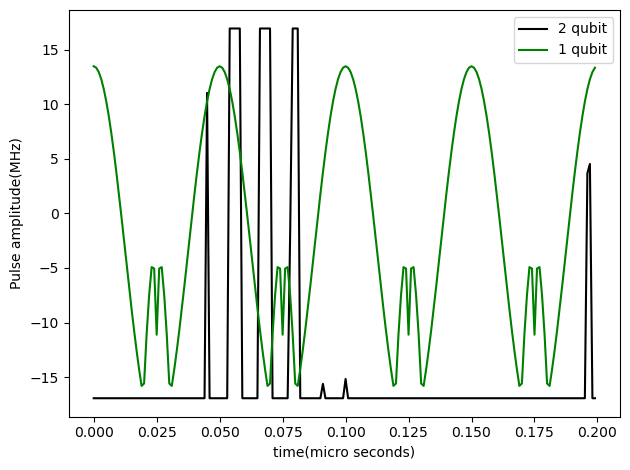

Fidelity :  0.992229413226308


Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 9.93055814e-01+5.55111512e-17j -3.02821173e-04+1.14189469e-01j
  -1.96887322e-04-1.75992828e-02j -1.43012914e-02-1.69269730e-02j]
 [-3.02821173e-04+1.14189469e-01j  9.93055814e-01-3.40005801e-13j
  -1.43012914e-02-1.69269730e-02j -1.96887322e-04-1.75992828e-02j]
 [ 1.56328649e-02-1.57053693e-02j  1.63016139e-03-1.75248495e-02j
   9.00351687e-03-1.13842908e-01j  9.89752564e-01+8.09182794e-02j]
 [ 1.63016139e-03-1.75248495e-02j  1.56328649e-02-1.57053693e-02j
   9.89752564e-01+8.09182794e-02j  9.00351687e-03-1.13842908e-01j]]

In [181]:
print(results.final_amps[:,0].shape)
plt.plot(results.time[:-1], 25.4*results.final_amps[:,0]*2/3,color = 'black', label='2 qubit')
#plt.plot(results.time[:-1], results.initial_amps[:,0],color = 'green')
#plt.tight_layout()
#plt.show()
#print(results.final_amps[:,1].shape)
plt.plot(results.time[:-1], 25.4*results.final_amps[:,1]*2/3,color = 'green', label='1 qubit')
#plt.plot(results.time[:-1], 25.4*np.sin(2*np.pi*(f_1-f_2)*np.linspace(0,0.2,200)),color = 'green', label='1 qubit')
#plt.plot(results.time[:-1], results.initial_amps[:,1],color = 'green')
plt.xlabel("time(micro seconds)")
plt.ylabel('Pulse amplitude(MHz)')
plt.tight_layout()
plt.legend()
plt.savefig("pulse.png")

plt.show()
U=results.evo_full_final
print("Fidelity : ",1-results.fid_err)
U*np.exp(-1j*cmath.polar(U[0][0])[1])

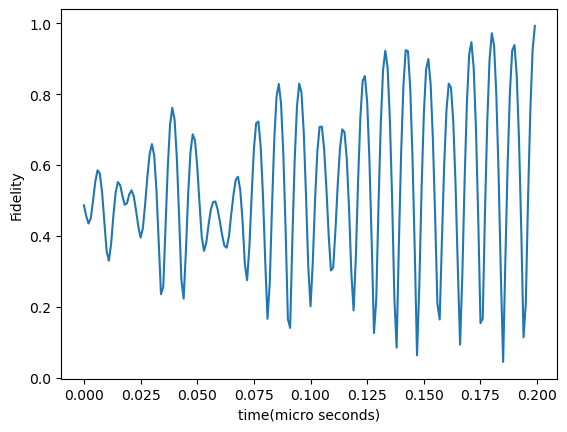

In [179]:
from scipy.linalg import expm
U=identity(4)
fid=[]
for i in range(len(results.final_amps[:,1])):
    U=Qobj(expm(0.001*1j*(H_d.full()+results.final_amps[i,0]*H_c[0].full()+results.final_amps[i,1]*H_c[1].full())))*U
    fid.append(np.abs((Qobj(U_targ.dag().full())*U).tr())/4)
#U=U*np.exp(-1j*cmath.polar(U[0][0])[1])
plt.xlabel("time(micro seconds)")
plt.ylabel('Fidelity')
plt.plot(results.time[:-1],fid)

plt.savefig("fidelity.png")

plt.show()

In [ ]:
import os
files = [f for f in os.listdir() if os.path.isfile(f)]

In [ ]:
# Load the data from the text file, assuming the file is space-separated or tab-separated


# Replace 'your_file.txt' with the path to your actual file
data = np.loadtxt('F_0.9600129729571389fno8_CNOT_n_ts_199_2_level.txt')

# Extract the last 4 columns
last_four_columns = data[:, -2:]

# Print or return the resulting 2D numpy array
#print(np.array(last_four_columns))
plt.plot(last_four_columns)
#dyn.initialize_controls(last_four_columns)